In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS
**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**Ansiedad**:   1

#DATOS DE PRUEBA

In [ ]:
num_docs = 100000
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/train.csv'
#data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train = data.iloc[:num_docs, :]
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     100000 non-null  object 
 1   TWEET_ID    99989 non-null   float64
 2   TWEET_TEXT  99963 non-null   object 
 3   trastorno   100000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null_values = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null_values)

Número de filas nulas o vacías en la columna 'trastorno': 0


In [ ]:
# Eliminar filas con valores nulos en la columna 'trastorno'
data_train = data_train.dropna(subset=['trastorno'])

# Verificar si hay filas nulas o vacías en la columna 'trastorno' después de eliminarlas
null_values = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno' después de eliminarlas:", null_values)

Número de filas nulas o vacías en la columna 'trastorno' después de eliminarlas: 0


In [ ]:
data_train['trastorno'] = data_train['trastorno'].astype('int64')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     100000 non-null  object 
 1   TWEET_ID    99989 non-null   float64
 2   TWEET_TEXT  99963 non-null   object 
 3   trastorno   100000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


#Preprocesamiento de los datos

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_es = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Eliminar etiquetas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpieza del texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # Tokenizar el texto en palabras
        words = text.split()

        # Eliminar palabras vacías
        words = [word for word in words if word not in stopwords_es]

        # Reconstruir el texto limpio
        text = ' '.join(words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

*lematizar y extraer términos*

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     100000 non-null  object 
 1   TWEET_ID    99989 non-null   float64
 2   TWEET_TEXT  100000 non-null  object 
 3   trastorno   100000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,mayoría piba gustar tener pierna grande lindo ...,1
1,6,2.147484e+09,sintiéndote solo,1
2,279,2.147484e+09,mier lindo escrachan magnifico,0
3,518,2.147484e+09,,0
4,301,2.147484e+09,seguir cumple deber pronto vestido novia estar...,0
5,177,2.147484e+09,dejar dormir prójimo,0
6,45,2.147484e+09,querer vivir cansado,1
7,29,2.147484e+09,poquito vergüenza alguien querer alzar yo peso...,1
8,388,2.147484e+09,related,0
9,31,2.147484e+09,mucho gana escribirtar decirte extraño deber h...,1


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 6821


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


#Vectorización de los datos


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def Tokenizer(text):
    return text.split()  # Tokenizador simple: divide el texto en palabras
# Crear un transformador CountVectorizer con el tokenizer Tokenizery rango de n-gramas (1, 1)
# y un umbral de frecuencia mínimo de 200
umbral = 20
count_vect = CountVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)

# Aplicar el CountVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz BoW
bow_train = count_vect.fit_transform(data_train['TWEET_TEXT'].values)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es:", len(count_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = bow_train  # Matriz BoW
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'

El tamaño del vocabulario es: 2987


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 70  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:


# Crear un modelo de SVM
model = SVC(kernel='linear', C=100, probability=False)

# Entrenar el modelo en los datos de entrenamiento transformados por LDA
model.fit(X_train_lda, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test_lda)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")

# Calcular la precisión, recall y puntuación F1
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")


Exactitud del modelo: 61.88%
Precisión: 62.07%
Recall: 61.88%
Puntuación F1: 61.65%


In [ ]:
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")

Exactitud del modelo: 61.88%
Precisión: 62.07%
Recall: 61.88%
Puntuación F1: 61.65%


# **Matrix de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(X_test_lda)

# Definir un umbral para etiquetar las predicciones
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades

# Convertir las predicciones continuas en etiquetas binarias
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)

# Calcular la proporción de ejemplos positivos en los datos reales
prop_real = np.sum(y_test) / len(y_test)

# Calcular la proporción de ejemplos etiquetados como positivos en función de la matriz de confusión
prop_etiquetados = (cm[0, 1] + cm[1, 1]) / len(y_test)

# Imprimir la matriz de confusión y las proporciones
print("Matriz de confusión:\n", cm, "\n")
print('Proporción de comentarios positivos en datos reales: %.2f' % prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f' % prop_etiquetados)


Matriz de confusión:
 [[9814 4318]
 [6338 7484]] 

Proporción de comentarios positivos en datos reales: 0.49
Proporción de comentarios positivos etiquetados: 0.42


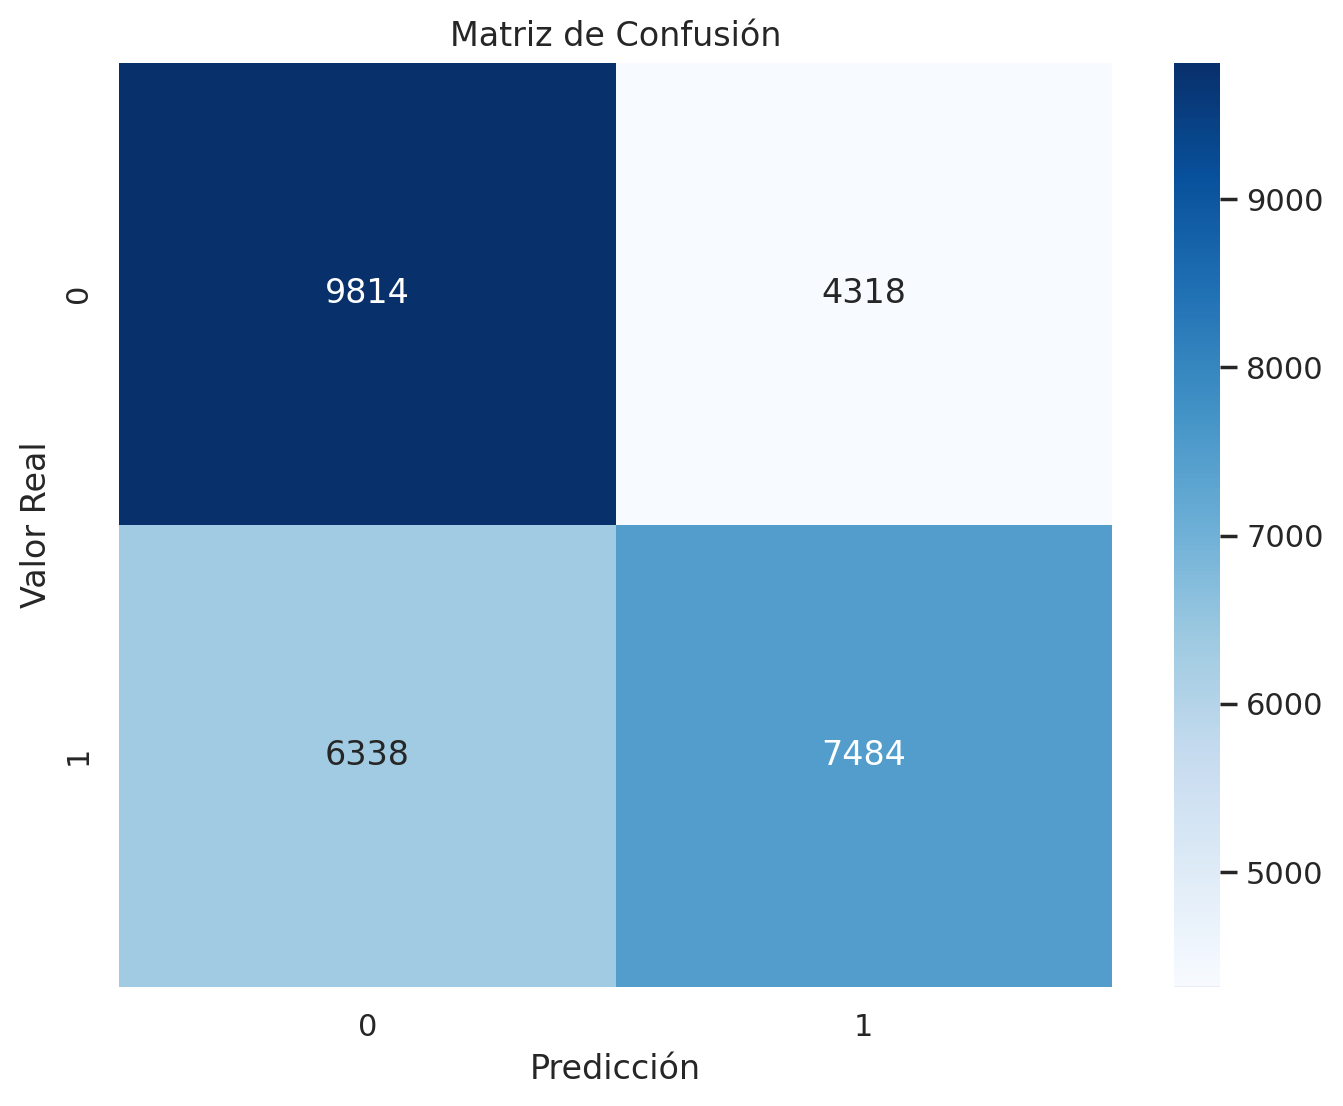

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Aprensizaje del modelo: SVM
**Validación Cruzada K=10**

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

# Supongamos que X es una lista de representaciones vectoriales Word2Vec y y son las etiquetas (0 o 1)

X_lda = X_train_lda
y = y_train

# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_lda, y):
    X_train_lda, X_val_lda = X_lda[train_index], X_lda[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear un modelo de SVM
    model = SVC(kernel='linear', C=100, probability=False)

    # Entrenar el SVM en los datos de entrenamiento del pliegue actual
    prev_score = 0  # Para verificar si mejora
    consecutive_no_improvement = 0  # Contador de iteraciones sin mejora
    max_consecutive_no_improvement = 1  # Número máximo por entrenamiento

    while consecutive_no_improvement < max_consecutive_no_improvement:
        model.fit(X_train_lda, y_train)

        # Predecir en el conjunto de validación
        y_val_pred = model.predict(X_val_lda)
        score = accuracy_score(y_val, y_val_pred)

        if score > prev_score:
            prev_score = score
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            print(f"Iteración {consecutive_no_improvement}: Accuracy en Validación = {score:.2f}")
            print("Entrenamiento finalizado.")

    # Predecir en el conjunto de entrenamiento del pliegue actual
    y_train_pred = model.predict(X_train_lda)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train, y_train_pred))
    train_precision_scores.append(precision_score(y_train, y_train_pred))
    train_recall_scores.append(recall_score(y_train, y_train_pred))
    train_f1_scores.append(f1_score(y_train, y_train_pred))

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(prev_score)  # Usamos el mejor puntaje obtenido
    val_precision_scores.append(precision_score(y_val, y_val_pred))
    val_recall_scores.append(recall_score(y_val, y_val_pred))
    val_f1_scores.append(f1_score(y_val, y_val_pred))

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas promediadas
print("Métricas de entrenamiento promediadas:")
print(f"Exactitud: {train_accuracy_mean * 100:.2f}%")
print(f"Precisión: {train_precision_mean * 100:.2f}%")
print(f"Recuperación: {train_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {train_f1_mean * 100:.2f}%")

print("\nMétricas de validación promediadas:")
print(f"Exactitud: {val_accuracy_mean * 100:.2f}%")
print(f"Precisión: {val_precision_mean * 100:.2f}%")
print(f"Recuperación: {val_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {val_f1_mean * 100:.2f}%")


Iteración 1: Accuracy en Validación = 0.62
Entrenamiento finalizado.
Iteración 1: Accuracy en Validación = 0.62
Entrenamiento finalizado.
Iteración 1: Accuracy en Validación = 0.62
Entrenamiento finalizado.
Iteración 1: Accuracy en Validación = 0.63
Entrenamiento finalizado.
Iteración 1: Accuracy en Validación = 0.62
Entrenamiento finalizado.
Métricas de entrenamiento promediadas:
Exactitud: 62.21%
Precisión: 63.43%
Recuperación: 54.59%
Puntuación F1: 58.68%

Métricas de validación promediadas:
Exactitud: 62.19%
Precisión: 63.42%
Recuperación: 54.51%
Puntuación F1: 58.62%


In [ ]:
# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))
print('------------------------------------------------------------------')
# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

Entrenamiento - Accuracy: 62.21%
Entrenamiento - Precision: 63.43%
Entrenamiento - Recall: 54.59%
Entrenamiento - F1 Score: 58.68%
------------------------------------------------------------------
Validación - Accuracy: 62.19%
Validación - Precision: 63.42%
Validación - Recall: 54.51%
Validación - F1 Score: 58.62%


# **Matrix de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(X_val_lda)

# Definir un umbral para etiquetar las predicciones
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades

# Convertir las predicciones continuas en etiquetas binarias
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)

# Calcular la proporción de ejemplos positivos en los datos reales
prop_real = np.sum(y_val) / len(y_val)

# Calcular la proporción de ejemplos etiquetados como positivos en función de la matriz de confusión
prop_etiquetados = (cm[0, 1] + cm[1, 1]) / len(y_val)

# Imprimir la matriz de confusión y las proporciones
print("Matriz de confusión:\n", cm, "\n")
print('Proporción de comentarios positivos en datos reales: %.2f' % prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f' % prop_etiquetados)


Matriz de confusión:
 [[4582 2052]
 [2863 3548]] 

Proporción de comentarios positivos en datos reales: 0.49
Proporción de comentarios positivos etiquetados: 0.43


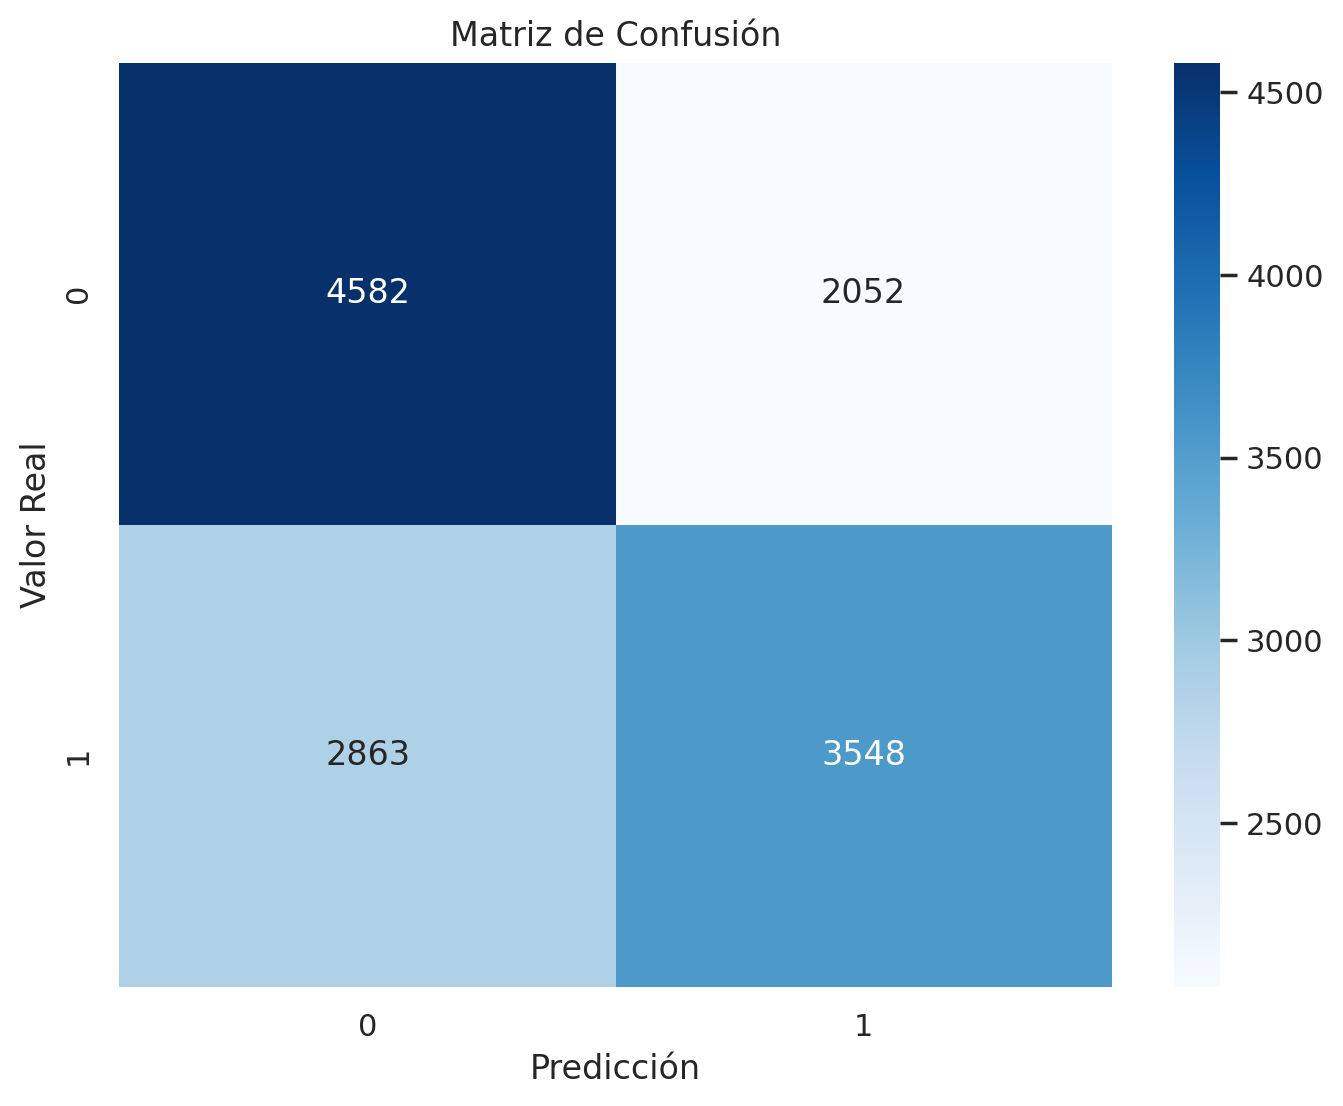

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()